# UCM analysis

2018-08-23

In [90]:
%matplotlib inline
import ipdb as pdb
import os
import matplotlib.pyplot as plt
from matplotlib import cm
# import mpl_toolkits.mplot3d.art3d as art3d

from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets.embed import embed_minimal_html
import ipywidgets as widgets
import seaborn as sns
sns.set(rc={'figure.facecolor':'white'})

import pandas as pd
import numpy as np
import numdifftools as nd
# from tools.utils import *
from time import gmtime, strftime
import tensorflow as tf
from train import *
from utils import *

## Load data

In [91]:
params = get_param('model/test', which_epoch=2000)  # model parameters
phn2idx = np.load('phn2idx.npy').item()
idx2phn = np.load('idx2phn.npy').item()
pca = np.load('fft_linfilt_pca.npy').item()
# fft_all = np.load('fft_all.npy')
labels = np.load('labels.npy')

X_reduced = np.load('fft_linfilt_pca_reduced.npy')
X_scaler = np.load('fft_linfilt_pca_reduced_scaler.npy').item()
X_std = X_scaler.transform(X_reduced)
phones = [*phn2idx]

model_dir: model/test
which_epoch: 2000
INFO:tensorflow:Restoring parameters from model/test/model_epoch=2000


In [92]:
X_reduced.shape, X_std.shape, fft_all.shape

((38777, 15), (38777, 15), (38777, 40))

In [93]:
X_std.mean(axis=0), X_std.std(axis=0)

(array([-9.16248220e-17,  1.31261533e-16,  1.83172340e-16,  2.92509710e-16,
        -1.10028815e-15,  1.03408899e-15,  3.66728336e-16,  3.34232188e-16,
        -6.40932837e-17, -7.03376977e-17, -6.93957389e-17, -4.04512624e-17,
        -3.82461052e-16,  3.86447915e-16, -2.15445167e-16]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [94]:
vowels = ['IY1','AE1','AA1','UW1']

## Define forward mapping function

In [95]:
def softmax_stable(X):
    e_x = np.exp(X - np.max(X), dtype=np.float32)
    if len(X.shape) > 1:
        return np.true_divide(e_x, np.tile(np.sum(e_x, axis=1, keepdims=True), e_x.shape[1]))
    else:
        return np.true_divide(e_x, np.sum(e_x))

def softmax_raw(X):
    X = np.reshape(X, (1, -1)) # reshape for output convenience
    e_x = np.exp(X, dtype=np.float32)
    return np.true_divide(e_x, np.tile(np.sum(e_x, axis=1, keepdims=True), e_x.shape[1]))

def forward(X):
    '''
    This function requires ANN hyper-parameters and sigmoid function
    from outside.
    They were separated for calculating Jacobian matrix (numdifftools)
    '''
    W1, W2, W3, W4 = params['W1'], params['W2'], params['W3'], params['W4']
    b1, b2, b3, b4 = params['b1'], params['b2'], params['b3'], params['b4']
    L1 = relu(np.dot(X, W1) + b1) # Nx300
    L2 = relu(np.dot(L1, W2) + b2) # Nx300
    L3 = relu(np.dot(L2, W3) + b3) # Nx300
    L4 = np.dot(L3, W4) + b4 # Nx3000
    return softmax_stable(L4)

def predict(model_dir, which_epoch, indata, outdata=None):
    tf.reset_default_graph()

    print('model_dir:', model_dir)
    print('final_epoch:', which_epoch)
    print('indata:', indata.shape)
    if outdata is not None:
        print('outdata:', outdata.shape)

    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(
            os.path.join(model_dir, 'model_epoch={}.meta'.format(which_epoch)))
        saver.restore(sess, os.path.join(
            model_dir, 'model_epoch={}'.format(which_epoch)))
        graph = tf.get_default_graph()

        # retrieve variables
        X = graph.get_tensor_by_name('X:0')
        Y = graph.get_tensor_by_name('Y:0')
        keep_prob = graph.get_tensor_by_name('keep_prob:0')
        pred = graph.get_tensor_by_name('prediction:0')
        accuracy = graph.get_tensor_by_name('accuracy:0')
        logits = graph.get_tensor_by_name('logits:0')
        softmax = graph.get_tensor_by_name('softmax:0')
        if outdata is not None:
            cost = graph.get_tensor_by_name('cost/cost:0')
            yhat, error, acc, logits_out, softmax_out = sess.run(
                [pred, cost, accuracy, logits, softmax], 
                feed_dict={X: indata, Y: outdata, keep_prob:1.0})
            return yhat, error, acc, logits_out, softmax_out
        else:
            yhat, logits_out, softmax_out = sess.run([pred, logits, softmax], feed_dict={X: indata, keep_prob:1.0})
            return yhat, logits_out, softmax_out

## Get vowel reference

In [96]:
meanAcous = np.zeros((len(vowels),15))
for i, v in enumerate(vowels):
    idx, _ = find_elements(v, labels)
    meanAcous[i,:] = np.mean(X_std[idx,:], axis=0) # scaled (=input to ANN)

In [97]:
meanAcous.shape, meanAcous

((4, 15),
 array([[ 0.17175882,  1.4319294 , -0.61789085,  0.29297495,  0.31450495,
          0.14119209,  0.28454834, -0.1663265 ,  0.00548495,  0.12102518,
          0.01533155,  0.07627468, -0.13263472, -0.12830147,  0.01192978],
        [-0.5498489 , -0.21359787, -0.21323753,  0.18133871,  0.0290237 ,
         -0.45274826, -0.13924289, -0.22146681,  0.28530418,  0.08738285,
          0.08456578, -0.24945892,  0.02133775,  0.40715171,  0.33067254],
        [-0.1226101 , -1.15818481,  0.19543353, -0.13768627, -0.03973256,
          0.0749189 ,  0.00916566, -0.16022604,  0.02191638, -0.04245857,
         -0.04874292, -0.15011056, -0.29176903,  0.11705209,  0.47161512],
        [ 0.89071975,  0.50168469,  0.16127343,  0.13187967, -0.27582788,
         -0.09909912, -0.40388686,  0.43281504, -0.13879469, -0.18301792,
         -0.05388988,  0.18967483,  0.00705875, -0.5260732 , -0.27114192]]))

In [98]:
# Validate forward mapping function with meanAcous
my_softmax_out = forward(meanAcous)
max_prob = np.max(my_softmax_out, axis=1)
print([p for p in max_prob])
print([idx2phn[i] for i in np.argmax(my_softmax_out, axis=1)])

[0.55323446, 0.6454434, 0.46158904, 0.5013483]
['IY1', 'AE1', 'AA1', 'UW1']


In [99]:
yhat, logits_out, tf_softmax_out = predict('model/test', which_epoch=5000, indata=meanAcous)

model_dir: model/test
final_epoch: 5000
indata: (4, 15)
INFO:tensorflow:Restoring parameters from model/test/model_epoch=5000


In [100]:
my_softmax_out, tf_softmax_out

(array([[7.77453603e-03, 4.17937408e-05, 9.62910326e-06, 1.02333818e-03,
         3.08816999e-01, 5.55493251e-09, 5.53234458e-01, 1.27486005e-01,
         1.61325047e-03],
        [6.45443380e-01, 7.62353837e-02, 2.66811568e-02, 2.10156560e-01,
         2.68467180e-02, 1.39972214e-02, 9.03831897e-05, 6.17913884e-06,
         5.43086382e-04],
        [1.10653125e-01, 1.60103515e-01, 1.85253292e-01, 8.23105648e-02,
         4.46575759e-05, 4.61589038e-01, 4.47483970e-08, 2.63095986e-11,
         4.56235248e-05],
        [3.04445550e-02, 2.64280196e-02, 1.26537553e-03, 2.83246543e-02,
         2.49218464e-01, 1.03723527e-04, 1.71421450e-02, 5.01348317e-01,
         1.45724759e-01]], dtype=float32),
 array([[1.02824476e-02, 1.20273427e-04, 1.56378665e-05, 2.47034687e-03,
         2.66288310e-01, 6.47364073e-09, 6.27631307e-01, 9.21197683e-02,
         1.07190164e-03],
        [5.46638310e-01, 1.76194251e-01, 1.10198362e-02, 2.10155457e-01,
         4.70106341e-02, 7.49635836e-03, 7.8715005

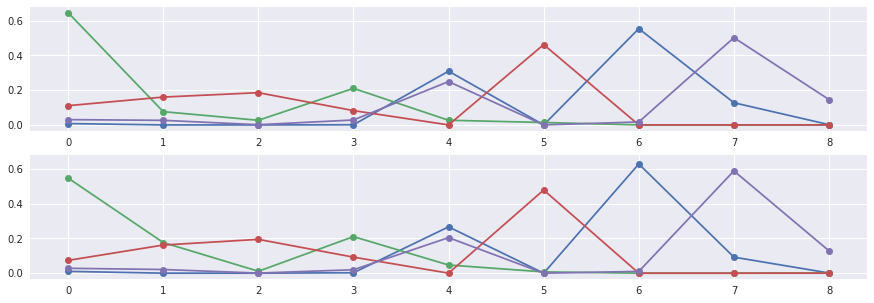

In [101]:
fig, (ax1, ax2) = plt.subplots(2,1,facecolor='white',figsize=(15,5), sharey=True)
ax1.plot(my_softmax_out.T, 'o-');
ax2.plot(tf_softmax_out.T, 'o-');

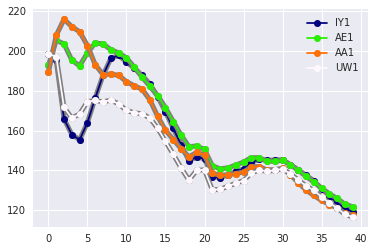

In [102]:
fig, ax = plt.subplots(facecolor='white')
color_dx = np.linspace(0.0, 1.0, len(vowels))
colors = [cm.gist_ncar(x) for x in color_dx]
plots = []
for i, c in enumerate(colors):
    x_unscaled = X_scaler.inverse_transform(meanAcous[i]).T
    x_recovered = pca.inverse_transform(x_unscaled)
    ax.plot(x_recovered, 'o-', linestyle='-', linewidth=5, color='gray');
    plots.append(ax.plot(x_recovered, 'o-', color=c));
ax.legend(handles=[p[0] for p in plots], labels=[v for v in vowels]);

## Choose your vowel

In [103]:
which_vowel = 'IY1'
idx, _ = find_elements(which_vowel, vowels)
init_pcs = meanAcous[idx]
print('init_pcs:\n\n', init_pcs)

init_pcs:

 [[ 0.17175882  1.4319294  -0.61789085  0.29297495  0.31450495  0.14119209
   0.28454834 -0.1663265   0.00548495  0.12102518  0.01533155  0.07627468
  -0.13263472 -0.12830147  0.01192978]]


## Get Jacobian

Shape= (9, 15)


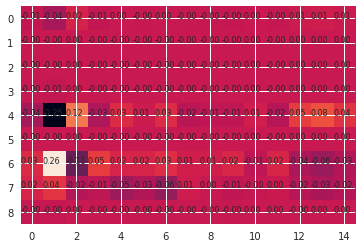

In [104]:
jacob = nd.Jacobian(forward)
J = jacob(np.squeeze(init_pcs))
print('Shape=', J.shape)

fig, ax = plt.subplots(facecolor='white')
ax.imshow(J, aspect='auto');
for i in range(J.shape[0]):
    for j in range(J.shape[1]):
        ax.text(j-0.5, i, f'{J[i,j]:.2f}', fontsize=8);

In [105]:
# Validate this --> True
forward(init_pcs), forward(np.squeeze(init_pcs))

(array([[7.7745351e-03, 4.1793715e-05, 9.6291060e-06, 1.0233384e-03,
         3.0881700e-01, 5.5549290e-09, 5.5323452e-01, 1.2748601e-01,
         1.6132501e-03]], dtype=float32),
 array([7.7745351e-03, 4.1793715e-05, 9.6291060e-06, 1.0233384e-03,
        3.0881700e-01, 5.5549290e-09, 5.5323452e-01, 1.2748601e-01,
        1.6132501e-03], dtype=float32))

Shape= (15, 6)


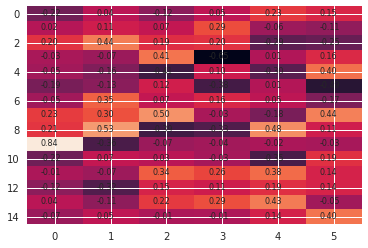

In [106]:
# Null space of Jacobian
ucm_vec = nullspace(J)
print('Shape=', ucm_vec.shape)
# print(ucm_vec)
fig, ax = plt.subplots(facecolor='white')
ax.imshow(ucm_vec, aspect='auto');
for i in range(ucm_vec.shape[0]):
    for j in range(ucm_vec.shape[1]):
        ax.text(j-0.25, i+0.1, f'{ucm_vec[i,j]:.2f}', fontsize=8);

## UCM analysis

In [137]:
def pca_ucm_plot(ucm1,ucm2,ucm3,ucm4,ucm5,ucm6):
    fig = plt.figure(facecolor='white', figsize=(15,5))
    
    # Get data
    weighted_ws = np.multiply(ucm_vec, np.tile([ucm1,ucm2,ucm3,ucm4,ucm5,ucm6], [15,1])) # 15x6
    PC_scaled = (init_pcs + np.sum(weighted_ws, axis=1))[0] # (15,)
    
    # Recover spectrum
    x_reduced = X_scaler.inverse_transform(PC_scaled)
    x_recon = pca.inverse_transform(x_reduced) # 1x40
    # Draw spectrum
    ax1 = fig.add_subplot(121)
    ax1.plot(x_recon, 'o-')
    ax1.set_xticks(range(40))
    ax1.set_xticklabels([f'{t+1:d}' for t in range(40)])
    ax1.set_ylim([60,220])
    ax1.tick_params(rotation=90)
    ax1.set_xlabel('40 Filters (reconstructed from 15 PCs)')
    
    # Softmax (bar)
    ax2 = fig.add_subplot(122)
    ax2.bar(range(9), forward(PC_scaled))
    ax2.yaxis.set_ticks(np.linspace(0,1,11))
    ax2.set_yticklabels([f'{t:.1f}' for t in np.linspace(0, 1, 11)])
    ax2.set_xlabel('9 selected vowels')
    ax2.set_ylabel('Probability')
    ax2.set_xticklabels([p for p in phones])
#     fig.tight_layout(pad=3)
    fig.subplots_adjust()

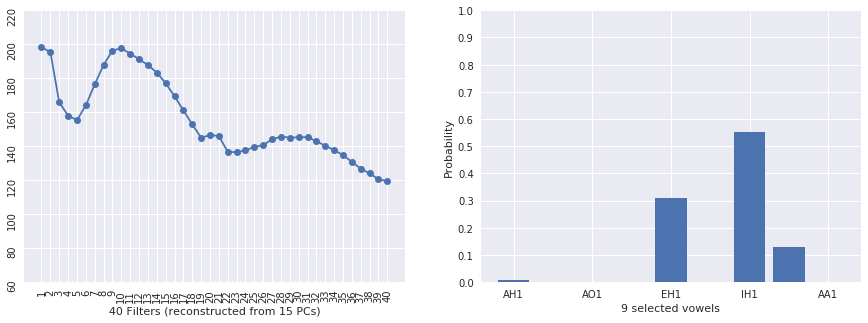

In [147]:
slider1 = widgets.FloatSlider(min=-3,max=3,step=0.1,value=0, 
                              layout=widgets.Layout(width='50%'))
slider2 = widgets.FloatSlider(min=-3,max=3,step=0.1,value=0,
                              layout=widgets.Layout(width='50%'))
slider3 = widgets.FloatSlider(min=-3,max=3,step=0.1,value=0,
                              layout=widgets.Layout(width='50%'))
slider4 = widgets.FloatSlider(min=-3,max=3,step=0.1,value=0,
                              layout=widgets.Layout(width='50%'))
slider5 = widgets.FloatSlider(min=-3,max=3,step=0.1,value=0,
                              layout=widgets.Layout(width='50%'))
slider6 = widgets.FloatSlider(min=-3,max=3,step=0.1,value=0,
                              layout=widgets.Layout(width='50%'))
interactive_plot = interactive(pca_ucm_plot, 
                               ucm1=slider1, ucm2=slider2, ucm3=slider3,
                               ucm4=slider4, ucm5=slider5, ucm6=slider6)
output = interactive_plot.children[-1]
interactive_plot

## CM analysis